In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jan 12 17:16:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   35C    P8    38W / 250W |  10778MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
## 50 epochs using 4 of Will's files with batch_size = 48 should take
##  just over 8 hours
folder = '11Jan2021_TracksToHists_B_Iter11B_100epochs_lr_3em5_b48_2p5_kde2hists_float_all_4x_will'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
## reduce batch size from 64 to 32 when floating all the parameters
##  it *appears* that storing the gradients requires extra memory
##  batch_size = 32 --> 6623MiB / 11019 MiB on sleepy RTX2081 Ti
batch_size = 48
# How fast to learn
## learning rate was 1e-7 for all layers in TracksToHists_A
## here we want to learn only weights in the finalFilter layer
## of TracksToHists_B, so try a high learning rate, at least initially
## 1e-3 did well for the first 10 epochs; let's increase it for the next 40
## reduce to 1e-3 for iteration with KDE_to_Hists weights floated
##  cost decreased monotonically in previous run, so increase lr to 2e-3
##  tried running with lr = 2e-3 and the validation cost function 
##  bounced around.  Want to try using a lower learning rate and
##  a larger training sample
##  Iter5B --  float all, leave learning rate = 5e-4
##  Iter6C, with lr = 1e-5 rather than 1e-6, seems to be learning more quickly,
##  so increase the learning rate to 1e-5 for Iter7B
##  training sample xost decreased almost monotonically for Iter8B, so increase to 3e-5 for Iter9B
##  (recalling that a higher learning rate introduced many fluctuations around a decreasing trend line
##    in a past experiment, but also produced a greater decrease altogether)

## for Iter11B, continue with learning_rate = 3e-5 as the cost function continued to frop almost monotonically
## in Iter10B; 
learning_rate = 3e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_B as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(1)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## 210109 let's use some of Will's toy MC for training rather than the 20K sample I've been using

##train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
train_loader = collect_t2hists_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                    '/share/lazy/will/data/June30_2020_80k_2.h5',
                                    '/share/lazy/will/data/June30_2020_80k_3.h5',
                                    '/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
##                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## 210109 and use everything in this 20K file for validation
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
##                           slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
len(X) =  80000
len(Xlist) =  1
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 107.1 s
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  222
len(pocaMx[1]) =  133
len(pocaMx[2]) =  259
len(pocaMx[3]) =  114
len(pocaMx[4]) =  143
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 222
 iEvt, nTrks =  1 133
 iEvt, nTrks =  2 259
 iEvt, nTrks =  3 114
 iEvt, nTrks =  4 143
 iEvt, nTrks =  5 136
 iEvt, nTrks =  6 397
 iEvt, nTrks =  7 370
 iEvt, nTrks =  8 97
 iEvt, nTrks =  9 67
len(X) =  80000
len(Xlist) =  2
Loa

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa

## 210110 For Iter0, freeze all weights other than those asociated with
## the finalFilter added in moving from TracksToHists_A to TracksToHists_B

## for "float_KDE_to_Hists" loop over ct<17
## for float_all loope over ct < 0
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder ='11Jan2021_TracksToHists_B_Ite10B_50epochs_lr_3em5_b48_2p5_kde2hists_float_all_4x_will'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


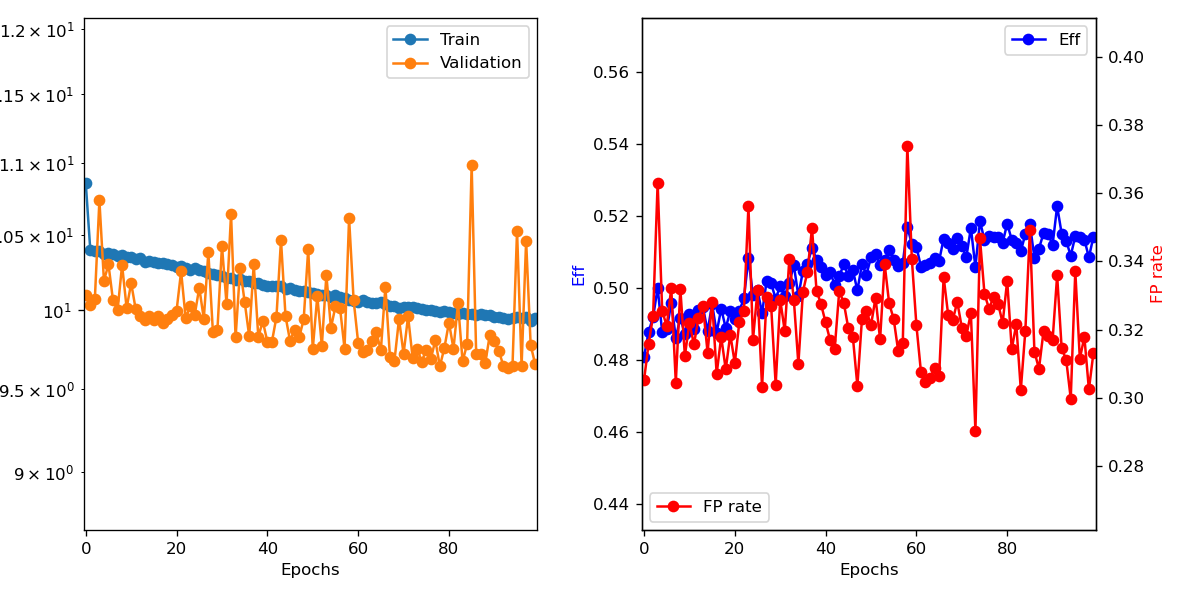

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 6667, val = 417


Epoch 0: train=10.8546, val=10.0951, took 590.56 s
  Validation Found 51947 of 108024, added 6104 (eff 48.09%) (0.305 FP/event)


Epoch 1: train=10.3926, val=10.0303, took 594.95 s
  Validation Found 52689 of 108024, added 6314 (eff 48.78%) (0.316 FP/event)


Epoch 2: train=10.3895, val=10.0704, took 591.45 s
  Validation Found 53140 of 108024, added 6482 (eff 49.19%) (0.324 FP/event)


Epoch 3: train=10.3898, val=10.7363, took 590.94 s
  Validation Found 54017 of 108024, added 7263 (eff 50.00%) (0.363 FP/event)


Epoch 4: train=10.3694, val=10.1897, took 590.8 s
  Validation Found 52690 of 108024, added 6511 (eff 48.78%) (0.326 FP/event)


Epoch 5: train=10.3737, val=10.2981, took 590.66 s
  Validation Found 52773 of 108024, added 6421 (eff 48.85%) (0.321 FP/event)


Epoch 6: train=10.3688, val=10.0602, took 591.54 s
  Validation Found 53556 of 108024, added 6644 (eff 49.58%) (0.332 FP/event)


Epoch 7: train=10.3569, val=9.99597, took 590.49 s
  Validation Found 52522 of 108024, added 6090 (eff 48.62%) (0.304 FP/event)


Epoch 8: train=10.3615, val=10.2938, took 590.72 s
  Validation Found 53118 of 108024, added 6639 (eff 49.17%) (0.332 FP/event)


Epoch 9: train=10.345, val=10.0115, took 591.08 s
  Validation Found 52641 of 108024, added 6247 (eff 48.73%) (0.312 FP/event)


Epoch 10: train=10.3494, val=10.1739, took 590.79 s
  Validation Found 53221 of 108024, added 6440 (eff 49.27%) (0.322 FP/event)


Epoch 11: train=10.3356, val=10.0022, took 590.56 s
  Validation Found 52786 of 108024, added 6313 (eff 48.87%) (0.316 FP/event)


Epoch 12: train=10.3395, val=9.9626, took 590.98 s
  Validation Found 53344 of 108024, added 6471 (eff 49.38%) (0.324 FP/event)


Epoch 13: train=10.3153, val=9.93495, took 591.28 s
  Validation Found 53429 of 108024, added 6538 (eff 49.46%) (0.327 FP/event)


Epoch 14: train=10.3179, val=9.9613, took 591.44 s
  Validation Found 52713 of 108024, added 6265 (eff 48.80%) (0.313 FP/event)


Epoch 15: train=10.3169, val=9.93543, took 590.86 s
  Validation Found 53530 of 108024, added 6563 (eff 49.55%) (0.328 FP/event)


Epoch 16: train=10.3062, val=9.96064, took 591.2 s
  Validation Found 52673 of 108024, added 6141 (eff 48.76%) (0.307 FP/event)


Epoch 17: train=10.3103, val=9.91254, took 590.91 s
  Validation Found 53395 of 108024, added 6358 (eff 49.43%) (0.318 FP/event)


Epoch 18: train=10.3038, val=9.93849, took 590.58 s
  Validation Found 52810 of 108024, added 6167 (eff 48.89%) (0.308 FP/event)


Epoch 19: train=10.2922, val=9.96462, took 590.74 s
  Validation Found 53322 of 108024, added 6371 (eff 49.36%) (0.319 FP/event)


Epoch 20: train=10.2843, val=9.99426, took 590.64 s
  Validation Found 53079 of 108024, added 6204 (eff 49.14%) (0.31 FP/event)


Epoch 21: train=10.2886, val=10.2512, took 590.96 s
  Validation Found 53324 of 108024, added 6446 (eff 49.36%) (0.322 FP/event)


Epoch 22: train=10.2751, val=9.94576, took 590.65 s
  Validation Found 53701 of 108024, added 6512 (eff 49.71%) (0.326 FP/event)


Epoch 23: train=10.2595, val=10.0244, took 591.23 s
  Validation Found 54901 of 108024, added 7125 (eff 50.82%) (0.356 FP/event)


Epoch 24: train=10.2726, val=9.96775, took 591.03 s
  Validation Found 53789 of 108024, added 6340 (eff 49.79%) (0.317 FP/event)


Epoch 25: train=10.2643, val=10.1439, took 591.06 s
  Validation Found 53944 of 108024, added 6631 (eff 49.94%) (0.332 FP/event)


Epoch 26: train=10.2526, val=9.94172, took 590.93 s
  Validation Found 53260 of 108024, added 6061 (eff 49.30%) (0.303 FP/event)


Epoch 27: train=10.2438, val=10.3798, took 591.65 s
  Validation Found 54215 of 108024, added 6589 (eff 50.19%) (0.329 FP/event)


Epoch 28: train=10.2366, val=9.85851, took 591.06 s
  Validation Found 54154 of 108024, added 6539 (eff 50.13%) (0.327 FP/event)


Epoch 29: train=10.2295, val=9.87013, took 591.09 s
  Validation Found 53684 of 108024, added 6078 (eff 49.70%) (0.304 FP/event)


Epoch 30: train=10.2192, val=10.4239, took 590.96 s
  Validation Found 54078 of 108024, added 6575 (eff 50.06%) (0.329 FP/event)


Epoch 31: train=10.2092, val=10.039, took 590.91 s
  Validation Found 53764 of 108024, added 6392 (eff 49.77%) (0.32 FP/event)


Epoch 32: train=10.208, val=10.6394, took 591.68 s
  Validation Found 54166 of 108024, added 6813 (eff 50.14%) (0.341 FP/event)


Epoch 33: train=10.1971, val=9.82146, took 591.4 s
  Validation Found 54694 of 108024, added 6576 (eff 50.63%) (0.329 FP/event)


Epoch 34: train=10.2021, val=10.2715, took 590.7 s
  Validation Found 53770 of 108024, added 6198 (eff 49.78%) (0.31 FP/event)


Epoch 35: train=10.1874, val=10.0509, took 591.39 s
  Validation Found 54526 of 108024, added 6622 (eff 50.48%) (0.331 FP/event)


Epoch 36: train=10.187, val=9.82989, took 591.7 s
  Validation Found 54725 of 108024, added 6739 (eff 50.66%) (0.337 FP/event)


Epoch 37: train=10.1746, val=10.2997, took 591.08 s
  Validation Found 55223 of 108024, added 6996 (eff 51.12%) (0.35 FP/event)


Epoch 38: train=10.1759, val=9.82654, took 591.81 s
  Validation Found 54866 of 108024, added 6629 (eff 50.79%) (0.331 FP/event)


Epoch 39: train=10.1637, val=9.92496, took 590.9 s
  Validation Found 54632 of 108024, added 6549 (eff 50.57%) (0.327 FP/event)


Epoch 40: train=10.1556, val=9.7944, took 590.5 s
  Validation Found 54415 of 108024, added 6442 (eff 50.37%) (0.322 FP/event)


Epoch 41: train=10.1558, val=9.79366, took 591.19 s
  Validation Found 54499 of 108024, added 6338 (eff 50.45%) (0.317 FP/event)


Epoch 42: train=10.1547, val=9.95295, took 591.09 s
  Validation Found 54098 of 108024, added 6287 (eff 50.08%) (0.314 FP/event)


Epoch 43: train=10.1523, val=10.4637, took 591.02 s
  Validation Found 54365 of 108024, added 6626 (eff 50.33%) (0.331 FP/event)


Epoch 44: train=10.1337, val=9.95798, took 591.46 s
  Validation Found 54719 of 108024, added 6558 (eff 50.65%) (0.328 FP/event)


Epoch 45: train=10.1428, val=9.8, took 590.96 s
  Validation Found 54378 of 108024, added 6409 (eff 50.34%) (0.32 FP/event)


Epoch 46: train=10.1311, val=9.87154, took 591.35 s
  Validation Found 54550 of 108024, added 6358 (eff 50.50%) (0.318 FP/event)


Epoch 47: train=10.1235, val=9.82199, took 591.09 s
  Validation Found 53938 of 108024, added 6070 (eff 49.93%) (0.303 FP/event)


Epoch 48: train=10.1247, val=9.93722, took 591.07 s
  Validation Found 54725 of 108024, added 6460 (eff 50.66%) (0.323 FP/event)


Epoch 49: train=10.1172, val=10.4009, took 591.0 s
  Validation Found 54416 of 108024, added 6510 (eff 50.37%) (0.325 FP/event)


Epoch 50: train=10.112, val=9.74775, took 590.94 s
  Validation Found 54932 of 108024, added 6426 (eff 50.85%) (0.321 FP/event)


Epoch 51: train=10.1034, val=10.0895, took 591.29 s
  Validation Found 55035 of 108024, added 6587 (eff 50.95%) (0.329 FP/event)


Epoch 52: train=10.0986, val=9.76707, took 591.76 s
  Validation Found 54710 of 108024, added 6343 (eff 50.65%) (0.317 FP/event)


Epoch 53: train=10.0981, val=10.229, took 590.57 s
  Validation Found 54853 of 108024, added 6786 (eff 50.78%) (0.339 FP/event)


Epoch 54: train=10.0858, val=9.88242, took 591.0 s
  Validation Found 55152 of 108024, added 6554 (eff 51.06%) (0.328 FP/event)


Epoch 55: train=10.0959, val=10.0218, took 591.37 s
  Validation Found 54847 of 108024, added 6462 (eff 50.77%) (0.323 FP/event)


Epoch 56: train=10.0797, val=10.0132, took 591.39 s
  Validation Found 54667 of 108024, added 6273 (eff 50.61%) (0.314 FP/event)


Epoch 57: train=10.0739, val=9.75105, took 590.95 s
  Validation Found 54753 of 108024, added 6321 (eff 50.69%) (0.316 FP/event)


Epoch 58: train=10.0607, val=10.613, took 590.89 s
  Validation Found 55845 of 108024, added 7480 (eff 51.70%) (0.374 FP/event)


Epoch 59: train=10.0566, val=10.063, took 591.49 s
  Validation Found 55333 of 108024, added 6813 (eff 51.22%) (0.341 FP/event)


Epoch 60: train=10.0495, val=9.78892, took 591.15 s
  Validation Found 55253 of 108024, added 6426 (eff 51.15%) (0.321 FP/event)


Epoch 61: train=10.0623, val=9.73117, took 591.05 s
  Validation Found 54652 of 108024, added 6153 (eff 50.59%) (0.308 FP/event)


Epoch 62: train=10.0523, val=9.73964, took 591.53 s
  Validation Found 54690 of 108024, added 6091 (eff 50.63%) (0.305 FP/event)


Epoch 63: train=10.0443, val=9.7973, took 590.72 s
  Validation Found 54767 of 108024, added 6114 (eff 50.70%) (0.306 FP/event)


Epoch 64: train=10.0448, val=9.85562, took 591.74 s
  Validation Found 54922 of 108024, added 6176 (eff 50.84%) (0.309 FP/event)


Epoch 65: train=10.049, val=9.73981, took 590.67 s
  Validation Found 54821 of 108024, added 6126 (eff 50.75%) (0.306 FP/event)


Epoch 66: train=10.0365, val=10.1516, took 591.22 s
  Validation Found 55493 of 108024, added 6709 (eff 51.37%) (0.335 FP/event)


Epoch 67: train=10.0261, val=9.70067, took 591.12 s
  Validation Found 55347 of 108024, added 6486 (eff 51.24%) (0.324 FP/event)


Epoch 68: train=10.0261, val=9.6743, took 591.06 s
  Validation Found 55179 of 108024, added 6454 (eff 51.08%) (0.323 FP/event)


Epoch 69: train=10.0144, val=9.94078, took 590.62 s
  Validation Found 55505 of 108024, added 6564 (eff 51.38%) (0.328 FP/event)


Epoch 70: train=10.0197, val=9.7177, took 590.7 s
  Validation Found 55263 of 108024, added 6412 (eff 51.16%) (0.321 FP/event)


Epoch 71: train=10.0205, val=9.95709, took 590.43 s
  Validation Found 54937 of 108024, added 6365 (eff 50.86%) (0.318 FP/event)


Epoch 72: train=10.0193, val=9.69163, took 590.69 s
  Validation Found 55816 of 108024, added 6498 (eff 51.67%) (0.325 FP/event)


Epoch 73: train=10.0095, val=9.75092, took 590.96 s
  Validation Found 54637 of 108024, added 5805 (eff 50.58%) (0.29 FP/event)


Epoch 74: train=10.0026, val=9.66953, took 591.27 s
  Validation Found 56015 of 108024, added 6935 (eff 51.85%) (0.347 FP/event)


Epoch 75: train=9.99667, val=9.74436, took 590.25 s
  Validation Found 55451 of 108024, added 6609 (eff 51.33%) (0.33 FP/event)


Epoch 76: train=9.99825, val=9.68347, took 591.02 s
  Validation Found 55557 of 108024, added 6523 (eff 51.43%) (0.326 FP/event)


Epoch 77: train=9.99016, val=9.8041, took 591.13 s
  Validation Found 55529 of 108024, added 6591 (eff 51.40%) (0.33 FP/event)


Epoch 78: train=9.9872, val=9.63991, took 590.76 s
  Validation Found 55545 of 108024, added 6551 (eff 51.42%) (0.328 FP/event)


Epoch 79: train=9.99465, val=9.75614, took 590.94 s
  Validation Found 55370 of 108024, added 6440 (eff 51.26%) (0.322 FP/event)


Epoch 80: train=9.98656, val=9.91693, took 590.79 s
  Validation Found 55944 of 108024, added 6688 (eff 51.79%) (0.334 FP/event)


Epoch 81: train=9.97824, val=9.75001, took 590.68 s
  Validation Found 55457 of 108024, added 6285 (eff 51.34%) (0.314 FP/event)


Epoch 82: train=9.97302, val=10.0416, took 590.46 s
  Validation Found 55358 of 108024, added 6432 (eff 51.25%) (0.322 FP/event)


Epoch 83: train=9.98168, val=9.66981, took 590.69 s
  Validation Found 55112 of 108024, added 6047 (eff 51.02%) (0.302 FP/event)


Epoch 84: train=9.97319, val=9.77911, took 590.73 s
  Validation Found 55630 of 108024, added 6395 (eff 51.50%) (0.32 FP/event)


Epoch 85: train=9.9703, val=10.9854, took 590.84 s
  Validation Found 55919 of 108024, added 6982 (eff 51.77%) (0.349 FP/event)


Epoch 86: train=9.96305, val=9.71419, took 591.37 s
  Validation Found 54915 of 108024, added 6270 (eff 50.84%) (0.313 FP/event)


Epoch 87: train=9.97124, val=9.71654, took 591.09 s
  Validation Found 55194 of 108024, added 6171 (eff 51.09%) (0.309 FP/event)


Epoch 88: train=9.96706, val=9.65887, took 590.89 s
  Validation Found 55654 of 108024, added 6390 (eff 51.52%) (0.319 FP/event)


Epoch 89: train=9.96838, val=9.83886, took 591.29 s
  Validation Found 55637 of 108024, added 6361 (eff 51.50%) (0.318 FP/event)


Epoch 90: train=9.95465, val=9.8014, took 590.54 s
  Validation Found 55305 of 108024, added 6338 (eff 51.20%) (0.317 FP/event)


Epoch 91: train=9.95486, val=9.73474, took 590.97 s
  Validation Found 56463 of 108024, added 6718 (eff 52.27%) (0.336 FP/event)


Epoch 92: train=9.94478, val=9.6426, took 591.93 s
  Validation Found 55642 of 108024, added 6290 (eff 51.51%) (0.314 FP/event)


Epoch 93: train=9.94324, val=9.63087, took 591.64 s
  Validation Found 55420 of 108024, added 6223 (eff 51.30%) (0.311 FP/event)


Epoch 94: train=9.94664, val=9.64306, took 590.94 s
  Validation Found 54983 of 108024, added 5996 (eff 50.90%) (0.3 FP/event)


Epoch 95: train=9.95593, val=10.5266, took 591.05 s
  Validation Found 55568 of 108024, added 6744 (eff 51.44%) (0.337 FP/event)


Epoch 96: train=9.94627, val=9.64067, took 591.1 s
  Validation Found 55543 of 108024, added 6229 (eff 51.42%) (0.311 FP/event)


Epoch 97: train=9.95318, val=10.4583, took 590.9 s
  Validation Found 55464 of 108024, added 6358 (eff 51.34%) (0.318 FP/event)


Epoch 98: train=9.93016, val=9.77372, took 591.17 s
  Validation Found 54929 of 108024, added 6049 (eff 50.85%) (0.302 FP/event)


Epoch 99: train=9.94789, val=9.65196, took 590.89 s
  Validation Found 55556 of 108024, added 6265 (eff 51.43%) (0.313 FP/event)



In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


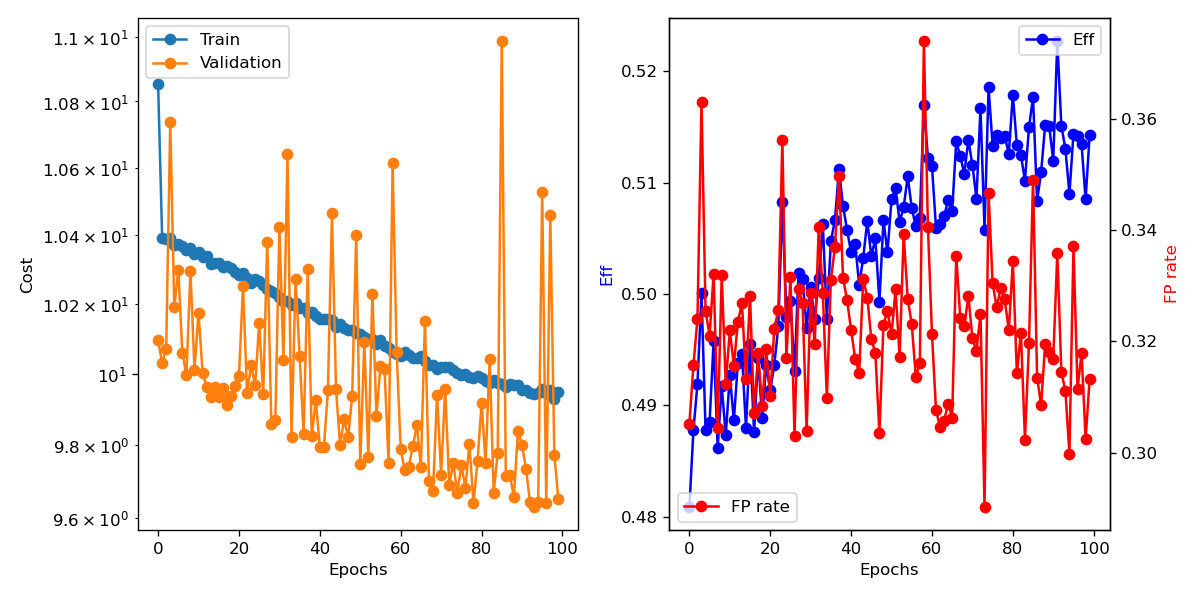

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [20]:
##torch.cuda.empty_cache()"
##quit()

